# Cvičení 6 - Hřebenová regrese, bias-variance tradeoff

V tomto notebooku se budeme zabývat: 
* hřebenovou regresí 
* analýzou vztahu vychýlení a rozptylu
* základními statistickými vlastnostmi odhadu

In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation (so 0.000 is printed as 0.)

## Načtení dat

Využijeme opět data o cenách domů v oblasti Bostonu v USA ([více info zde](https://www.kaggle.com/c/boston-housing)), která máme tentokrát v mírně modifikované variantě uložená v souboru `data.csv`.

Data jsou již vyčištěná. Proměnná, kterou chceme predikovat je `medv`.

In [4]:
df = pd.read_csv('data.csv').astype('float64')
print('Shape', df.shape)
df.head()

Shape (333, 15)


,ID,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,1.0,0.00632,18.0,2.31,0.0,0.00538,0.06575,65.2,4.0900,1.0,29600.0,15.3,39690.0,4.98,24.0
1,2.0,0.02731,0.0,7.07,0.0,0.00469,0.06421,78.9,4.9671,2.0,24200.0,17.8,39690.0,9.14,21.6
2,4.0,0.03237,0.0,2.18,0.0,0.00458,0.06998,45.8,6.0622,3.0,22200.0,18.7,39463.0,2.94,33.4
3,5.0,0.06905,0.0,2.18,0.0,0.00458,0.07147,54.2,6.0622,3.0,22200.0,18.7,39690.0,5.33,36.2
4,7.0,0.08829,12.5,7.87,0.0,0.00524,0.06012,66.6,5.5605,5.0,31100.0,15.2,39560.0,12.43,22.9


### Příprava trénovací a testovací množiny

Využijeme [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) ze `scikit-learn`.

In [5]:
random_seed = 42

Xtrain, Xval, ytrain, yval = train_test_split(df.drop(columns = ['medv']), df['medv'], test_size=0.4, random_state=random_seed)
Xval, Xtest, yval, ytest = train_test_split(Xval, yval, test_size=0.3, random_state=random_seed)

print(f"Train rozměry, X: {Xtrain.shape}, y: {ytrain.shape}")
print(f"Val rozměry, X: {Xval.shape}, y: {yval.shape}")
print(f"Test rozměry, X: {Xtest.shape}, y: {ytest.shape}")

Train rozměry, X: (199, 14), y: (199,)
Val rozměry, X: (93, 14), y: (93,)
Test rozměry, X: (41, 14), y: (41,)


#### Vytvoříme model lineární regrese pro porovnání

w_hat_OLS: 36.5917 [   -0.0056     -0.06179     0.06238    -0.07662     0.05659 -1094.48187
   343.28908    -0.01942    -1.85337     0.42811    -0.00013    -0.68126
     0.00007    -0.65277]
Validační RMSE: 4.47518
Testovací RMSE: 4.57462


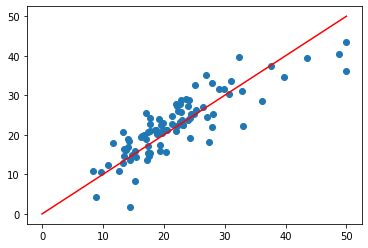

In [6]:
clf_lr = LinearRegression()
clf_lr.fit(Xtrain, ytrain)

print(f"w_hat_OLS: {clf_lr.intercept_:.4f}", clf_lr.coef_)

RMSE_val_lr = mean_squared_error(yval, clf_lr.predict(Xval), squared = False)
print(f'Validační RMSE: {RMSE_val_lr:.5f}')

RMSE_test_lr = mean_squared_error(ytest, clf_lr.predict(Xtest), squared = False)
print(f'Testovací RMSE: {RMSE_test_lr:.5f}')

plt.scatter(yval, clf_lr.predict(Xval))
plt.plot([0,50], [0,50], 'r')
plt.show()

## Úkol  - implementujte ručně model hřebenové regrese

Podobně jako v minulém cvičení využijte pouze funkce z `numpy`.

Do předpřipravené třídy `my_ridge` implementujte metody fit a predict, tak aby:
* metoda `fit` vyrobila odhad $\hat{\boldsymbol w}_{\lambda} = (\mathbf{X}^T \mathbf X + \lambda \mathbf{I}')^{-1} \mathbf X^T \boldsymbol Y$, uložila ho do proměnné `self.w_hat`.
* metoda `predict` spočítala na nových datech predikci.

V další části:
* Natrénujeme tento model pro $\lambda = 1$ (kvůli tomu, že má `lambda` speciální význam v Pythonu, tak parametr označíme alpha) a vypište jednotlivé koeficienty a intercept.
* Nakreslíme scatter plot hodnot $Y_i$ a $\hat Y_i$ pro validační množinu.
* Pro validační a testovací data provedeme predikce $\hat Y_i$ a porovnáme je se skutečnými hodnotami $Y_i$.
Jako míru porovnání použijeme RMSE.
* Porovnáme koeficienty získané lineární regresí a hřebenovou regresí. Provnáme výkonnosti obou modelů.

In [8]:
# Váš kód pro přípravu třídy zde

class my_ridge:
    """
    Třída reprezentující model hřebenové regrese s rozhraním shodným jako mají sklearn modely
    """
    def __init__(self, alpha):
        """
        V konstruktoru nastavíme hyperparametr lambda označený zde alpha
        """
        self.alpha = alpha
        self.w_hat = None
    #------------------------------------
    def fit(self, Xtrain, ytrain):
        """
        Trénování spočívá v sestrojení w_hat
        """
        X = np.matrix(np.concatenate([np.ones((Xtrain.shape[0],1)),np.array(Xtrain)], axis = 1))
        # Vektor Y
        Y = np.matrix(ytrain).T
        # Matice I`
        Iprime = np.eye(X.shape[1],X.shape[1])
        Iprime[0,0] = 0
        # Odhad
        w_hat = (X.T*X + self.alpha*Iprime).I*X.T*Y
        self.w_hat = np.array(w_hat).flatten()
    #------------------------------------
    def predict(self, Xdata):
        """
        Predikce pro daná data
        """
        if self.w_hat is None:
            return None
        
        X = np.matrix(np.concatenate([np.ones((Xdata.shape[0],1)),np.array(Xdata)], axis = 1))
        w_hat = np.matrix(self.w_hat).T
        yhat = X*w_hat
        return np.array(yhat).flatten()
    #------------------------------------
    @property
    def intercept_(self):
        """
        Intercept
        """
        return self.w_hat[0] if self.w_hat is not None else None
    #------------------------------------
    @property
    def coef_(self):
        """
        Remaining fitted parameters
        """
        return self.w_hat[1:] if self.w_hat is not None else None

w_hat_my_ridge: 55.5580 [-0.00338 -0.07241  0.08383 -0.18837  0.06403 -0.0779   1.68729 -0.01085
 -1.75004  0.49338 -0.0002  -0.62878  0.00006 -0.84579]
Validační RMSE: 5.17836
Testovací RMSE: 5.48191


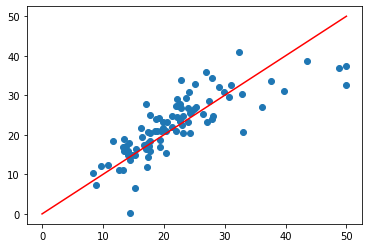

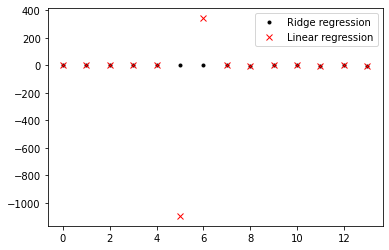

In [9]:
# Využijeme implementovanou třídu

clf_my_ridge = my_ridge(1)
clf_my_ridge.fit(Xtrain, ytrain)

print(f"w_hat_my_ridge: {clf_my_ridge.intercept_:.4f}", clf_my_ridge.coef_)

RMSE_val_my_ridge = mean_squared_error(yval, clf_my_ridge.predict(Xval), squared = False)
print(f'Validační RMSE: {RMSE_val_my_ridge:.5f}')

RMSE_test_my_ridge = mean_squared_error(ytest, clf_my_ridge.predict(Xtest), squared = False)
print(f'Testovací RMSE: {RMSE_test_my_ridge:.5f}')

plt.scatter(yval, clf_my_ridge.predict(Xval))
plt.plot([0,50], [0,50], 'r')
plt.show()

plt.plot(clf_my_ridge.coef_, 'k.', label="Ridge regression")
plt.plot(clf_lr.coef_, 'rx', label="Linear regression")
plt.legend()
plt.show()

## Úkol - model hrebeňovej regresie s využitím scikit-learn

* Zopakujte postup z předchozího bodu s využitím třídy [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) ze `scikit-learn`.
* Porovnejte naučené koeficienty a výkonnost modelu s ruční implementací.

w_hat_ridge: 55.5580 [-0.00338 -0.07241  0.08383 -0.18837  0.06403 -0.0779   1.68729 -0.01085
 -1.75004  0.49338 -0.0002  -0.62878  0.00006 -0.84579]
Validační RMSE: 5.17836
Testovací RMSE: 5.48191


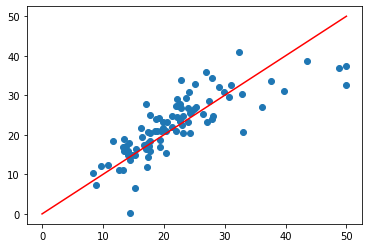

In [10]:
clf_ridge = Ridge(1)
clf_ridge.fit(Xtrain, ytrain)

print(f"w_hat_ridge: {clf_ridge.intercept_:.4f}", clf_ridge.coef_)

RMSE_val_ridge = mean_squared_error(yval, clf_ridge.predict(Xval), squared = False)
print(f'Validační RMSE: {RMSE_val_ridge:.5f}')

RMSE_test_ridge = mean_squared_error(ytest, clf_ridge.predict(Xtest), squared = False)
print(f'Testovací RMSE: {RMSE_test_ridge:.5f}')

plt.scatter(yval, clf_ridge.predict(Xval))
plt.plot([0,50], [0,50], 'r')
plt.show()

Vidíme, že jsme dostali přesně to samé, jako ruční implementací.

## Úkol - ladění hyperparametrů hřebenové regrese

* Nejprve pro několik různých hodnot $\lambda > 0$ vykreslete validační RMSE a odhadněte vhodný interval, ve kterém se bude nacházet optimální hodnota.
* Využijte funkci `scipy.optimize.minimize_scalar` k nalezení optimální hodnoty.
* Pro optimální hodnotu $\lambda$ natrénujte nový model.
* Výsledné RMSE pro testovací data porovnejte s předchozími výsledky.

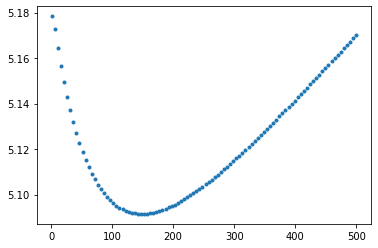

Optimal alpha      fun: 5.091517868022537
 message: 'Solution found.'
    nfev: 13
  status: 0
 success: True
       x: 148.4325041297702


Validační RMSE: 5.09152
Testovací RMSE: 5.54913


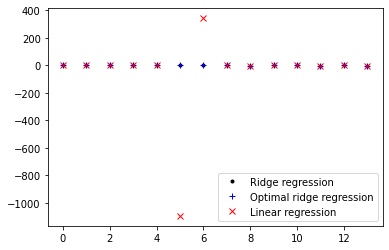

In [11]:
from scipy import optimize

def get_opt_ridge_model(Xtrain, Xval):
    def ridgemodel_eval(alpha):
        clf = Ridge(alpha=alpha)
        clf.fit(Xtrain, ytrain)
        return mean_squared_error(yval, clf.predict(Xval), squared = False)

    alphas = np.linspace(1,500,100)
    alphas_res = [ridgemodel_eval(alpha) for alpha in alphas]
    plt.plot(alphas, alphas_res, '.')
    plt.show()

    # Find Ridge alpha automatically
    opt_alpha = optimize.minimize_scalar(ridgemodel_eval, options = {'maxiter': 30}, method = 'bounded', bounds=(0.1, 400))
    print('Optimal alpha', opt_alpha)
    print("\n")

    clf_opt_ridge = Ridge(alpha = opt_alpha.x)
    clf_opt_ridge.fit(Xtrain, ytrain)
    return clf_opt_ridge

clf_opt_ridge = get_opt_ridge_model(Xtrain, Xval)
RMSE_val_opt_ridge = mean_squared_error(yval, clf_opt_ridge.predict(Xval), squared = False)
print(f'Validační RMSE: {RMSE_val_opt_ridge:.5f}')
RMSE_test_opt_ridge = mean_squared_error(ytest, clf_opt_ridge.predict(Xtest), squared = False)
print(f'Testovací RMSE: {RMSE_test_opt_ridge:.5f}')

plt.plot(clf_my_ridge.coef_, 'k.', label="Ridge regression")
plt.plot(clf_opt_ridge.coef_, 'b+', label="Optimal ridge regression")
plt.plot(clf_lr.coef_, 'rx', label="Linear regression")
plt.legend()
plt.show()

Vidíme, že jsme dostali pouze nepatrné vylepšení a klasická lineární regrese je zde stále lepší.

## Úkol - zopakujte předchozí úlohu pro standardizované příznaky
* Ke standardizaci využijte `sklearn.preprocessing.StandardScaler`.
* Výsledné RMSE pro testovací data porovnejte s výstupem lineární regrese a předchozí hřebenové regrese.

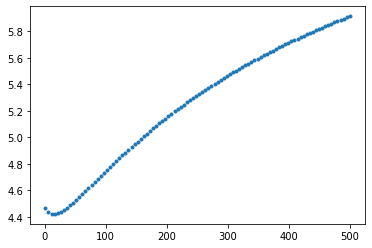

Optimal alpha      fun: 4.4209516038899945
 message: 'Solution found.'
    nfev: 14
  status: 0
 success: True
       x: 14.254044716564767


Validační RMSE: 4.42095
Testovací RMSE: 4.37455


In [12]:
from sklearn.preprocessing import StandardScaler

# Váš kód zde

scaler = StandardScaler().fit(Xtrain)

Xtrain_sc = scaler.transform(Xtrain)
Xval_sc = scaler.transform(Xval)
Xtest_sc = scaler.transform(Xtest)

clf_opt_ridge = get_opt_ridge_model(Xtrain_sc, Xval_sc)
RMSE_val_opt_ridge = mean_squared_error(yval, clf_opt_ridge.predict(Xval_sc), squared = False)
print(f'Validační RMSE: {RMSE_val_opt_ridge:.5f}')
RMSE_test_opt_ridge = mean_squared_error(ytest, clf_opt_ridge.predict(Xtest_sc), squared = False)
print(f'Testovací RMSE: {RMSE_test_opt_ridge:.5f}')

Vidíme, že teprve normalizace přinesla významné zlepšení modelu, který je nyní přesnější než původní lineární regrese.

## Vztah vychýlení a rozptylu
Na umělých datech numericky prozkoumáme vztah vychýlení a rozptylu.

<center><img src="img/tradeoff.jpeg" width="50%"></center>
<center>(zdroj: https://medium.com/@mp32445/understanding-bias-variance-tradeoff-ca59a22e2a83)</center>


Nejprve si připravíme funkce na náhodný výběr z modelu

X shape: (50, 5)


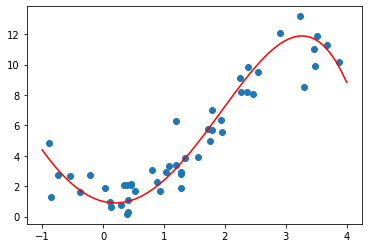

In [91]:
np.random.seed(3)  # zajistí replikovatelnost

# body x, kde budou data
x = np.random.rand(50)*5 - 1

# body x pro vykreslování
x_plot = np.linspace(-1,4,300)

# funkce, která vytvoří dataset - příznaky, jako mocniny x
def getX(x, max_degree = 5):
    X = x.reshape(-1,1)
    for i in range(2, max_degree+1):
        X = np.concatenate((X, (x**i).reshape(-1,1)), axis = 1)
    return X

# dataset pro X
X = getX(x)

# dataset pro vykreslení
X_plot = getX(x_plot)
print('X shape:', X.shape)

# příprava neznámého vektoru parametrů
true_intercept = 1
true_coefs = [-1,2.5,0,-0.11,0]

# funkce, která vrací náhodný výběr ze známého modelu
def getY(X, random = True, true_intercept = true_intercept, true_coefs = true_coefs):
    
    # vytvoření skutečného w
    w = np.concatenate((np.array([true_intercept] + true_coefs), np.zeros(1000)),)
    w = w[0:(X.shape[1]+1)]
    # přidání interceptu k matici příznaků
    Xx = np.concatenate((np.ones(X.shape[0]).reshape(-1,1),X), axis = 1)
    # nagenerujeme z modelu trénovací množiny střední hodnoty v bodech x
    EY = Xx.dot(w)
    # pokud je zapnutá náhodná odchylka, přidáme ji
    if random:
        # reset random seedu, aby to bylo náhodné
        np.random.seed()
        # přidání náhodné odchylky
        return EY + np.random.randn(X.shape[0])*1
    else:
        return EY

# vezmeme si jeden trénovací dataset
Y = getY(X)
# zobrazíme ho
plt.scatter(x,Y)

# vyrobíme si skutečné střední hodnoty
EY_plot = getY(X_plot, random = False)
plt.plot(x_plot, EY_plot, 'r')
plt.show()

### Nyní prozkoumáme vychýlení a rozptyl odhadu lineární a hřebenové regrese
Zafixujeme $\lambda = 0$ (alpha) a 100x provedeme:
* Nagenerování trénovacích hodnot $Y$.
* Predikci pomocí hřebenové regrese pro testovací hodnoty `X_plot`.

Výslednou predikci, tj. křivku dvojic `(x_plot, Yhat_plot)`, vykreslíme do jednoho grafu spolu se výběrovým průměrem přes všechny predikce.

Podíváme se na chování odhadu $\hat w$ (střední hodnotu).

Podíváme se, jak se výsledky mění v závislosti se zvyšujícím $\lambda$.

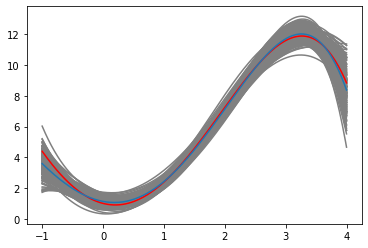

Mean intercept : 1.1296310737391797
True intercept : 1
---------------------

Mean coefs : [-0.74895  1.97029  0.17327 -0.09434 -0.00803]
True coefs : [-1, 2.5, 0, -0.11, 0]
---------------------

Mean Ridge Regression of squared Biases on test set : 0.036256947083593144
Mean Ridge Regression Variance on test set : 0.1365829981592914


In [102]:
def ridge_repeat(alpha = 1, N = 100, plot = True):
    Yres = np.zeros((N, X_plot.shape[0]))
    intercept_res = np.zeros((N, ))
    coef_res = np.zeros((N, X_plot.shape[1]))
    
    clf = Ridge(alpha = alpha)
    for i in range(N):
        clf.fit(X, getY(X))
        Yth_plot = clf.predict(X_plot)
        Yres[i,:] = Yth_plot
        intercept_res[i] = clf.intercept_
        coef_res[i,:] = clf.coef_
        if plot:
            if N % 2 == 0:
                plt.plot(x_plot,Yth_plot, 'gray')
                
    plt.plot(x_plot, EY_plot, 'r')
    plt.plot(x_plot, np.mean(Yres, axis = 0))
    plt.show()
    return Yres, intercept_res, coef_res


Yres, intercept_res, coef_res  = ridge_repeat(alpha = 1, N = 200)


# print těch různých statistik
# what
E_intercept_ridge = np.mean(intercept_res, axis=0)
print(f"Mean intercept : {E_intercept_ridge}")
print(f"True intercept : {true_intercept}")
print("---------------------\n")

E_coefs_ridge = np.mean(coef_res, axis=0)
print(f"Mean coefs : {E_coefs_ridge}")
print(f"True coefs : {true_coefs}")
print("---------------------\n")

# Yhat
E_Y_hat_ridge = np.mean(Yres, axis=0)
bias_ridge = E_Y_hat_ridge - EY_plot
var_ridge = np.var(Yres, axis=0)
print("Mean Ridge Regression of squared Biases on test set : " + str(np.mean(np.square(bias_ridge))))
print("Mean Ridge Regression Variance on test set : " + str(np.mean(var_ridge)))

Vidíme, že pro $\lambda = 0$ je odhad nestranný. Pro restoucí $\lambda$ přestane být nestranný a začně klesat variance.

Podívejme se na to, že v různých bodech je různý bias i variance.

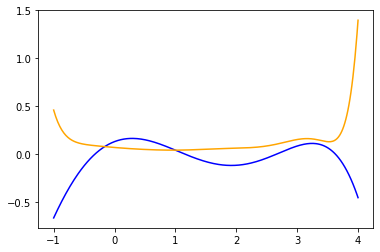

In [101]:
plt.plot(x_plot,bias_ridge, 'blue')
plt.plot(x_plot,np.var(Yres, axis = 0),'orange')
plt.show()